In [ ]:
!unzip "/content/data (3).zip"

Archive:  /content/data (3).zip
warning [/content/data (3).zip]:  18171299 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  18171299
  (attempting to re-compensate)
error: invalid zip file with overlapped components (possible zip bomb)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import required packages
import tensorflow as tf
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/drive/MyDrive/d_fer/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/drive/MyDrive/d_fer/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 12105 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Train the neural network/model with a smaller batch size
emotion_model_info = emotion_model.fit_generator(
    train_generator,
    steps_per_epoch=28709 // 256,  # Reduced batch size from 256 to 64
    epochs=10,
    validation_data=validation_generator,
    validation_steps=7178 // 256)  # Adjust validation steps accordingly


Epoch 1/10
190/190 [==============================] - ETA: 0s - loss: 1.3231 - accuracy: 0.3238 

In [ ]:
# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

In [ ]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.h5')

Testing a model

In [ ]:
import cv2
import numpy as np
from keras.models import model_from_json


emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [ ]:
# load json and create model
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

In [ ]:
# load weights into new model
emotion_model.load_weights("emotion_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
print(emotion_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [ ]:
image = cv2.imread('/content/images/train/angry/1.jpg')
print(image.shape)


(48, 48, 3)


In [ ]:
import cv2
import numpy as np
from keras.models import model_from_json

# Load JSON and create model
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# Load weights into new model
emotion_model.load_weights("emotion_model.h5")
print("Loaded model from disk")

# Load the image
image = cv2.imread('/content/images/images/validation/disgust/10053.jpg')  # Replace 'your_image.jpg' with the path to your image file

# Preprocess the image
# For example, resize the image to match the input size expected by your model
resized_image = cv2.resize(image, (48, 48))
# Optionally convert the image to grayscale if your model expects grayscale input
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
# You may need to further preprocess the image based on your model requirements

# Make predictions
# Assuming your model expects a 4D input tensor (batch_size, height, width, channels)
input_image = np.expand_dims(gray_image, axis=0)  # Add batch dimension
input_image = np.expand_dims(input_image, axis=-1)  # Add channel dimension if needed
predictions = emotion_model.predict(input_image)

# Process predictions
# For example, interpret the predicted class or probabilities
# You may need to post-process the predictions based on your model's output format
maxindex = int(np.argmax(predictions))
predicted_emotion = emotion_dict[maxindex]

# Overlay predicted emotion label on the original image
cv2.putText(image, predicted_emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Save the image with predictions overlay
output_image_path = '/content/images/output.jpg'
cv2.imwrite(output_image_path, image)

print(f"Results saved to {output_image_path}")


Loaded model from disk
1/1 [==============================] - 0s 88ms/step
Results saved to /content/images/output.jpg


Loaded model from disk
1/1 [==============================] - 0s 17ms/step


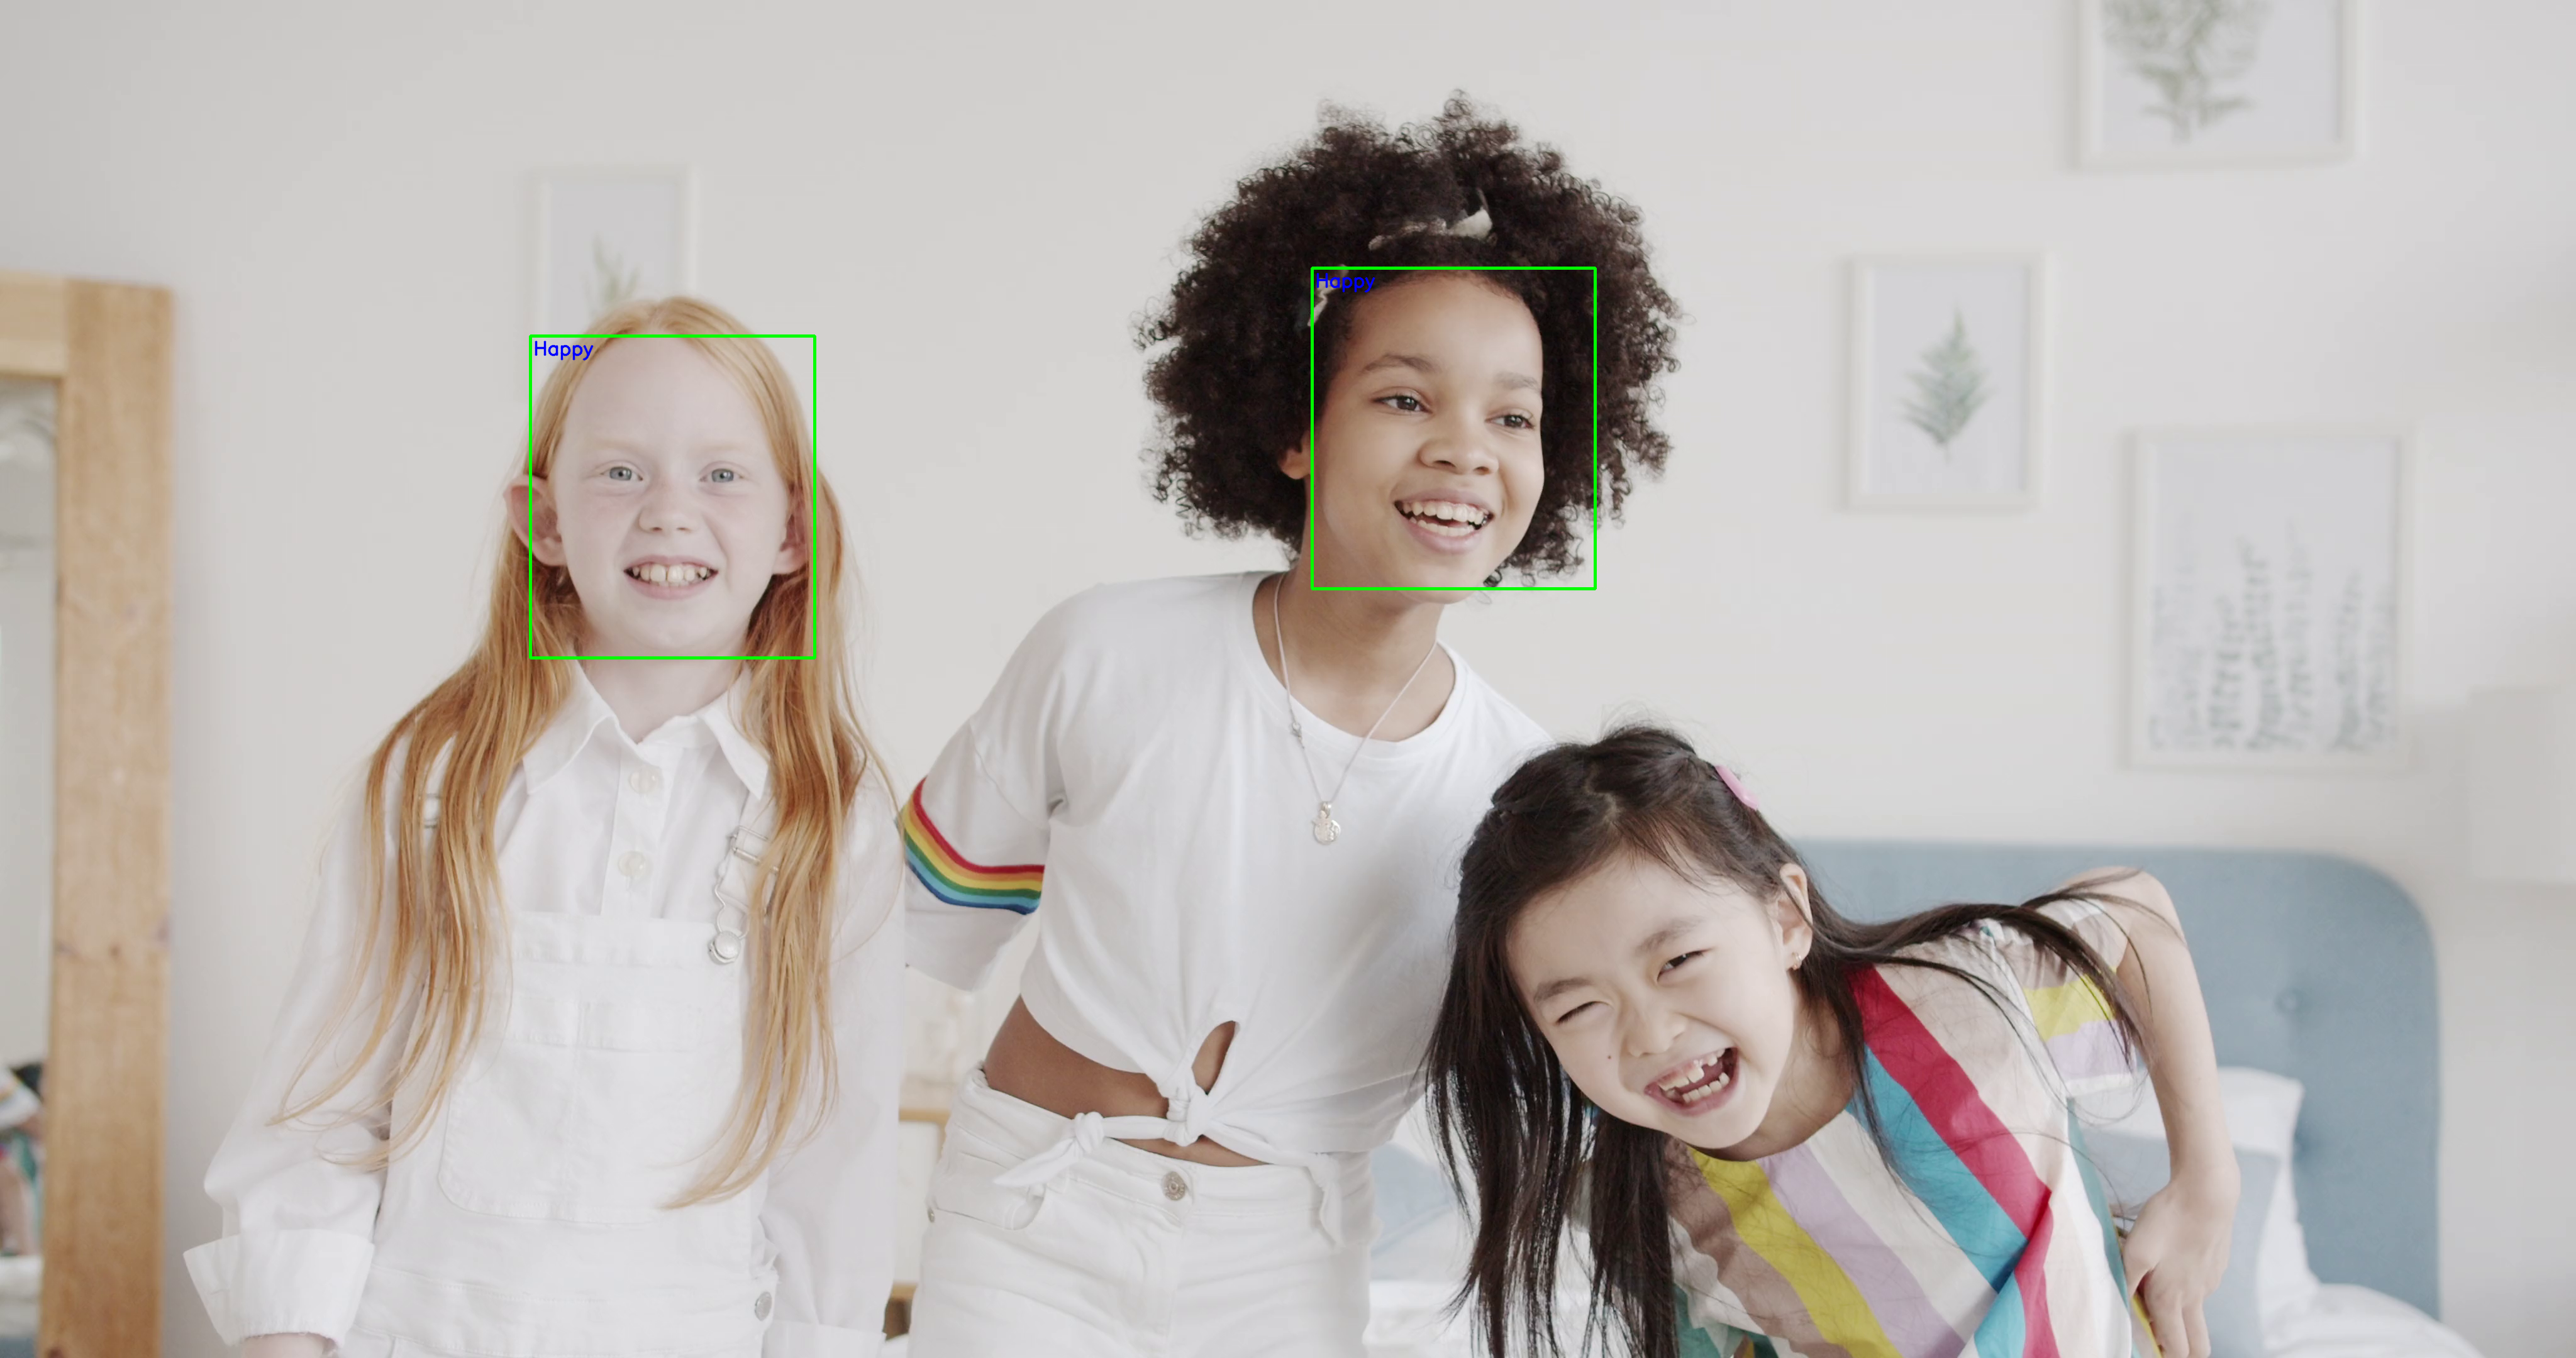

In [ ]:

import cv2
import numpy as np
from keras.models import model_from_json
from google.colab.patches import cv2_imshow


emotion_dict = {0: "Angry", 1: "Neutral", 2: "Neutral", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# Load JSON and create model
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# Load weights into new model
emotion_model.load_weights("emotion_model.h5")
print("Loaded model from disk")

# Start the webcam feed
# cap = cv2.VideoCapture(0)

# Pass here your video path
cap = cv2.VideoCapture("/content/pexels-gabby-k-5273028 (2160p).mp4")

# Initialize VideoWriter
out = cv2.VideoWriter('/content/sample_data/output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    # Capture the current frame
    ret, frame = cap.read()

    # If the frame is empty, break the loop
    if not ret:
        break
    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces available on camera
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    # Take each face available on the camera and preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Write frame to output video file
    out.write(frame)

    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release VideoWriter and capture object
out.release()
cap.release()
cv2.destroyAllWindows()


Evaluating Model

In [ ]:
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

In [ ]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}


In [ ]:
# load json and create model
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

In [ ]:
# load weights into new model
emotion_model.load_weights("emotion_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        'images/validation',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 7066 images belonging to 7 classes.


In [ ]:
# do prediction on test data
predictions = emotion_model.predict_generator(test_generator)

-----------------------------------------------------------------
[[130  13 119 265 175 155 103]
 [ 16   1  10  28  21  25  10]
 [125  14 118 281 180 183 117]
 [225  24 234 539 324 287 192]
 [162  14 146 312 208 244 130]
 [137   7 141 303 236 192 123]
 [ 92  10 102 239 145 130  79]]


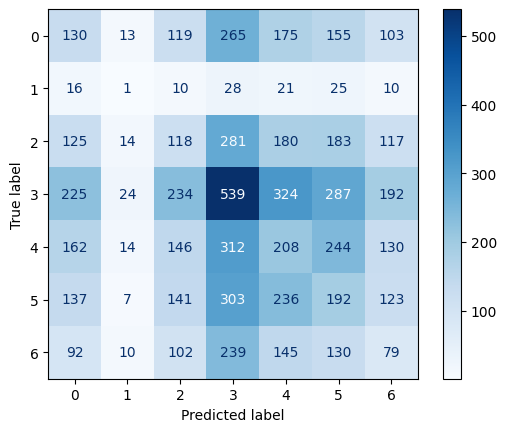

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.15      0.14      0.14       960
           1       0.01      0.01      0.01       111
           2       0.14      0.12      0.12      1018
           3       0.27      0.30      0.28      1825
           4       0.16      0.17      0.17      1216
           5       0.16      0.17      0.16      1139
           6       0.10      0.10      0.10       797

    accuracy                           0.18      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.18      0.18      0.18      7066



In [ ]:
# see predictions
# for result in predictions:
#     max_index = int(np.argmax(result))
#     print(emotion_dict[max_index])

print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))